In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import warnings
import contextlib
from datetime import datetime
import torch.multiprocessing as mp
import sys
mp.set_start_method('spawn')

In [17]:
from utils.datasets import *
from utils.eval import *
from utils.model import *

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_names = [
    "resnet50",
    "resnet18", "alexnet", "vgg16",
    "densenet", "inception", "googlenet", 
    "resnext50_32x4d", "wide_resnet50_2"
]

cuda


In [19]:
# freezed model
def get_original_model(net):
    if net == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # models.resnet18(pretrained=True)
    elif net == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # model = models.resnet18(pretrained=True)
    elif net == "alexnet":
        # model = models.alexnet(pretrained=True)
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    elif net == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        # model = models.vgg16(pretrained=True)
    elif net == "densenet":
        model = models.densenet161(weights=models.DenseNet161_Weights.DEFAULT)
        # model = models.densenet161(pretrained=True)
    elif net == "inception":
        model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        # model = models.inception_v3(pretrained=True)
    elif net == "googlenet":
        model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        # model = models.googlenet(pretrained=True)
    elif net == "resnext50_32x4d":
        model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
        # model = models.resnext50_32x4d(pretrained=True)
    elif net == "wide_resnet50_2":
        model = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT)
        # model = models.wide_resnet50_2(pretrained=True)
    else:
        raise ValueError("Invalid model name")
    for param in model.parameters():
        param.requires_grad = False
    # Remove the last fully connected layer
    if "inception" in net:
        model.aux_logits=False
        num_ftrs = model.fc.in_features
        model.fc = nn.Identity()
        model.fc = nn.Linear(2048, num_classes)
        model.fc.requires_grad = True
        optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    if "alexnet" in net or "vgg" in net or  "mobilenet_v3_large" in net:
        last_fc_layer = model.classifier[-1]
        num_ftrs = last_fc_layer.in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        model.classifier[-1].requires_grad = True
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif "densenet" in net:
        last_fc_layer = model.classifier
        num_ftrs = last_fc_layer.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        model.classifier.requires_grad = True
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    else:
        num_ftrs = model.fc.in_features
        model.fc = nn.Identity()
        model.fc.requires_grad = True
        model.fc = nn.Linear(num_ftrs, num_classes)
        optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    return model,criterion, optimizer

In [20]:
def train_net(net):
    model, criterion, optimizer = get_original_model(net)
    original_stderr = sys.stderr
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    tps, tns, fps, fns = [], [], [], []
    current_date = datetime.now().strftime('%Y-%m-%d')
    save_dir = os.path.join("saved_models/tl", current_date)
    os.makedirs(save_dir, exist_ok=True)
    num_epochs = 10
    sys.stderr = open(os.devnull, 'w')
    
    for timestamp in range(1, 290):
    # for timestamp in range(1, 20):
        debug = False
        if timestamp in  [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]:
            debug = True
        if debug:
            print("timestamp: ", timestamp)
        if "inception" in net:
            dataloaders = get_dataloaders(timestamp, inception=True)
        else:
            dataloaders = get_dataloaders(timestamp)
        model_trained, loss_values = train_model(model, criterion, optimizer, dataloaders, num_epochs=num_epochs, inception=("inception" in net), output=debug)
        model_filename = os.path.join(save_dir, f"model_{net}_time_{timestamp}_epochs{num_epochs}.pt")
        torch.save(model_trained.state_dict(), model_filename)
    
        accuracy, precision, recall, f1, tp, tn, fp, fn = get_metrics(model_trained, dataloaders['test'], inception=("inception" in net))
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        if debug:
            print("Accuracy: ", accuracy)
        recall_list.append(recall)
        f1_list.append(f1)
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
    sys.stderr = original_stderr
    return accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns

training resnet50...
timestamp:  1
Training complete in 0m 4s
Best val Acc: 0.500000
Accuracy:  0.25
timestamp:  20
Training complete in 0m 1s
Best val Acc: 0.750000
Accuracy:  0.625
timestamp:  40
Training complete in 0m 3s
Best val Acc: 0.750000
Accuracy:  0.375
timestamp:  60
Training complete in 0m 3s
Best val Acc: 0.625000
Accuracy:  0.875
timestamp:  80
Training complete in 0m 3s
Best val Acc: 0.875000
Accuracy:  0.875
timestamp:  100
Training complete in 0m 3s
Best val Acc: 0.875000
Accuracy:  0.875
timestamp:  120
Training complete in 0m 2s
Best val Acc: 0.875000
Accuracy:  0.875
timestamp:  140
Training complete in 0m 2s
Best val Acc: 1.000000
Accuracy:  0.875
timestamp:  160
Training complete in 0m 2s
Best val Acc: 1.000000
Accuracy:  0.875
timestamp:  180
Training complete in 0m 2s
Best val Acc: 1.000000
Accuracy:  1.0
timestamp:  200
Training complete in 0m 2s
Best val Acc: 1.000000
Accuracy:  1.0
timestamp:  220
Training complete in 0m 2s
Best val Acc: 1.000000
Accuracy:  

/home/myuser/projects/thesis/stem_cell_dl/src/utils/eval.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 8))


resnet18 average accuracy: 0.8957612456747405
training alexnet...
timestamp:  1
Training complete in 0m 1s
Best val Acc: 0.625000
Accuracy:  0.75
timestamp:  20
Training complete in 0m 1s
Best val Acc: 0.625000
Accuracy:  0.75
timestamp:  40
Training complete in 0m 1s
Best val Acc: 1.000000
Accuracy:  0.75
timestamp:  60
Training complete in 0m 1s
Best val Acc: 0.875000
Accuracy:  0.875
timestamp:  80
Training complete in 0m 0s
Best val Acc: 0.875000
Accuracy:  0.875
timestamp:  100
Training complete in 0m 1s
Best val Acc: 0.875000
Accuracy:  1.0
timestamp:  120
Training complete in 0m 0s
Best val Acc: 1.000000
Accuracy:  0.875
timestamp:  140
Training complete in 0m 0s
Best val Acc: 1.000000
Accuracy:  0.875
timestamp:  160
Training complete in 0m 1s
Best val Acc: 1.000000
Accuracy:  0.75
timestamp:  180
Training complete in 0m 0s
Best val Acc: 1.000000
Accuracy:  0.75
timestamp:  200
Training complete in 0m 1s
Best val Acc: 1.000000
Accuracy:  0.875
timestamp:  220
Training complete 

<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

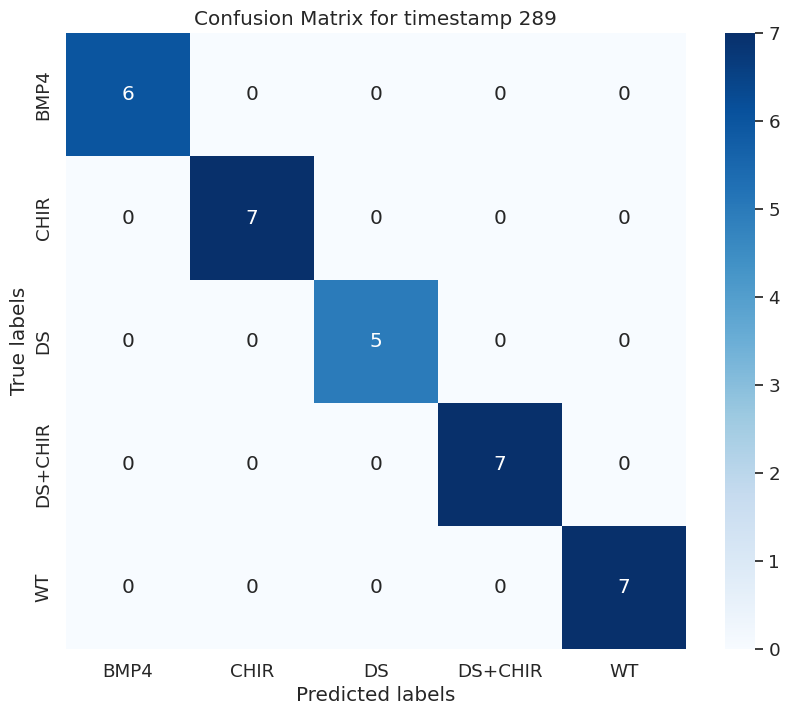

In [21]:
# for model in 
# accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns = train_net("googlenet")
model_names = [
    "resnet50",
    "resnet18", "alexnet", "vgg16",
    "densenet", "inception", "googlenet", 
    "resnext50_32x4d", "wide_resnet50_2"
]
acc_map = {}
pre_map = {}
rec_map = {}
f1_map = {}
tps_map = {}
tns_map = {}
fps_map = {}
fns_map = {}

for model_name in model_names:
    print(f"training {model_name}...")
    current_date = datetime.now().strftime('%Y-%m-%d')
    os.makedirs(f"./output/tl/{current_date}/{model_name}", exist_ok=True)
    show = False
    save = True
    accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns = train_net(model_name)
    plot_metric(accuracy_list, 'Accuracy', model=model_name, save=save, show=show, output=f"output/tl/{current_date}")
    plot_metric(precision_list, 'Precision', model=model_name, save=save, show=show,output=f"output/tl/{current_date}")
    plot_metric(recall_list, 'Recall', model=model_name, save=save, show=show,output=f"output/tl/{current_date}")
    plot_metric(f1_list, 'F1 Score', model=model_name, save=save, show=show,output=f"output/tl/{current_date}")
    for time in [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]: 
    # for time in [1, 3, 5]: 
        plot_confusion_matrix(tps, tns, fps, fns, time, save=save, show=show,output=f"./output/tl/{current_date}/{model_name}")
    acc_map[model_name] = accuracy_list
    pre_map[model_name] = precision_list
    rec_map[model_name] = recall_list
    f1_map[model_name] = f1_list
    tps_map[model_name] = tps
    tns_map[model_name] = tns
    fps_map[model_name] = fps
    fns_map[model_name] = fns

    print(f"{model_name} average accuracy:", sum(accuracy_list) / len(accuracy_list))

In [22]:
avg_acc_map = {model: sum(acc) / len(acc) for model, acc in acc_map.items()}
avg_pre_map = {model: sum(pre) / len(pre) for model, pre in pre_map.items()}
avg_rec_map = {model: sum(rec) / len(rec) for model, rec in rec_map.items()}
avg_f1_map = {model: sum(f1) / len(f1) for model, f1 in f1_map.items()}
print("Average Accuracy:")
for model, avg_acc in avg_acc_map.items():
    print(f"{model}: {avg_acc}")

print("\nAverage Precision:")
for model, avg_pre in avg_pre_map.items():
    print(f"{model}: {avg_pre}")

print("\nAverage Recall:")
for model, avg_rec in avg_rec_map.items():
    print(f"{model}: {avg_rec}")

print("\nAverage F1 Score:")
for model, avg_f1 in avg_f1_map.items():
    print(f"{model}: {avg_f1}")

output_folder = f"./output/tl/{current_date}"
output_file = "average_metrics.txt"

# Combine average metric values for all models into a single string
combined_metrics = ""
for model in model_names:
    if model in avg_acc_map:
        combined_metrics += f"{model} - Average Accuracy: {avg_acc_map[model]}, Average Precision: {avg_pre_map[model]}, Average Recall: {avg_rec_map[model]}, Average F1 Score: {avg_f1_map[model]}\n"

# Write the combined metrics string to the output file
with open(os.path.join(output_folder, output_file), "w") as f:
    f.write(combined_metrics)
    for model in model_names:
        if model in avg_acc_map:
            f.write(f"\n{model}:\n")
            f.write("Accuracy: " + str(acc_map[model]) + "\n")
            f.write("Precision: " + str(pre_map[model]) + "\n")
            f.write("Recall: " + str(rec_map[model]) + "\n")
            f.write("F1 Score: " + str(f1_map[model]) + "\n")
            f.write("TPs: " + str(tps_map[model]) + "\n")
            f.write("TNs: " + str(tns_map[model]) + "\n")
            f.write("FPs: " + str(fps_map[model]) + "\n")
            f.write("FNs: " + str(fns_map[model]) + "\n")

Average Accuracy:
resnet50: 0.8641868512110726
resnet18: 0.8957612456747405
alexnet: 0.870674740484429
vgg16: 0.8927335640138409
densenet: 0.9126297577854672
inception: 0.8771626297577855
googlenet: 0.8871107266435986
resnext50_32x4d: 0.8905709342560554
wide_resnet50_2: 0.8438581314878892

Average Precision:
resnet50: 0.7976355247981545
resnet18: 0.8194925028835044
alexnet: 0.8416955017301037
vgg16: 0.8527104959630913
densenet: 0.8447520184544399
inception: 0.8157900807381773
googlenet: 0.8258938869665509
resnext50_32x4d: 0.8340253748558241
wide_resnet50_2: 0.7464244521337932

Average Recall:
resnet50: 0.8381776239907731
resnet18: 0.860322952710497
alexnet: 0.8755478662053083
vgg16: 0.8826989619377175
densenet: 0.8772779700115348
inception: 0.8490196078431381
googlenet: 0.8626297577854682
resnext50_32x4d: 0.8663206459054221
wide_resnet50_2: 0.8040369088812007

Average F1 Score:
resnet50: 0.8061262151919593
resnet18: 0.8311649365628594
alexnet: 0.8365167243367921
vgg16: 0.85314549349151

In [23]:
# # model_names = [
# #     "resnet18",
# #     "alexnet", 
# #     "vgg16",
# #     "densenet",
# show_ = False
# save_ = True
# model_name = "densenet"
# accuracy_list = [0.625, 0.75, 0.75, 0.875, 0.75, 0.875, 1.0, 0.875, 0.875, 0.75, 1.0, 1.0, 0.625, 0.875, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.875, 0.75, 1.0, 1.0, 0.875, 0.625, 0.75, 0.875, 0.875, 0.75, 1.0, 1.0, 0.75, 0.875, 1.0, 1.0, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.75, 0.875, 0.875, 0.75, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875, 1.0, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.75, 0.875, 0.875, 0.875, 0.75, 0.875, 0.875, 0.875, 0.875, 1.0, 0.875, 0.75, 1.0, 0.875, 1.0, 0.875, 1.0, 1.0, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875, 0.875, 0.875, 0.875, 0.875, 0.75, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.875, 1.0, 1.0, 0.875, 0.75, 0.875, 1.0, 1.0, 1.0, 0.875, 1.0, 0.875, 0.75, 0.875, 1.0, 0.875, 0.875, 1.0, 0.875, 0.875, 0.75, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 1.0, 1.0, 0.875, 1.0, 0.875, 1.0, 1.0, 0.875, 0.75, 0.75, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.875, 1.0, 0.875, 0.875, 1.0, 0.875, 1.0, 0.875, 0.875, 0.875, 1.0, 1.0, 0.875, 0.75, 0.875, 1.0, 0.875, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.875, 1.0, 0.875, 0.875, 1.0, 0.875, 0.875, 0.875, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.875, 1.0, 0.875, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.75, 0.875, 0.875, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.875, 1.0, 1.0, 0.875]
# precision_list =[0.5666666666666667, 0.6, 0.7, 0.9, 0.7, 0.9, 1.0, 0.9, 0.9, 0.8, 1.0, 1.0, 0.4333333333333333, 0.7, 0.5333333333333333, 0.4, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.7333333333333333, 0.5333333333333333, 1.0, 1.0, 0.7333333333333333, 0.4666666666666666, 0.5333333333333333, 0.7333333333333333, 0.7333333333333333, 0.5333333333333333, 1.0, 1.0, 0.5, 0.7333333333333333, 1.0, 1.0, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.6, 0.7333333333333333, 0.7333333333333333, 0.5, 0.7333333333333333, 0.9, 0.7333333333333333, 0.5, 0.7, 0.9, 1.0, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.6, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.5, 0.7333333333333333, 0.9, 0.7333333333333333, 0.7333333333333333, 1.0, 0.7333333333333333, 0.6, 1.0, 0.7333333333333333, 1.0, 0.7333333333333333, 1.0, 1.0, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.9, 0.7333333333333333, 0.9, 0.7, 0.7, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.6, 0.7333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.7333333333333333, 1.0, 1.0, 0.7333333333333333, 0.6, 0.7333333333333333, 1.0, 1.0, 1.0, 0.7333333333333333, 1.0, 0.7333333333333333, 0.6, 0.7333333333333333, 1.0, 0.7333333333333333, 0.7333333333333333, 1.0, 0.7333333333333333, 0.7333333333333333, 0.6, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 1.0, 1.0, 0.7333333333333333, 1.0, 0.7333333333333333, 1.0, 1.0, 0.7333333333333333, 0.6, 0.6, 1.0, 1.0, 1.0, 0.7333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7333333333333333, 0.7333333333333333, 1.0, 0.9, 0.9, 1.0, 0.9, 1.0, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 1.0, 1.0, 0.7333333333333333, 0.6, 0.7333333333333333, 1.0, 0.7333333333333333, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.7333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7333333333333333, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 1.0, 0.7333333333333333, 0.7333333333333333, 1.0, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7333333333333333, 0.7333333333333333, 1.0, 0.7333333333333333, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.7333333333333333, 1.0, 1.0, 0.6666666666666666, 0.7333333333333333, 0.9, 1.0, 1.0, 0.7333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.7333333333333333, 1.0, 1.0, 0.9]
# recall_list = [0.6333333333333333, 0.8, 0.7, 0.9, 0.7, 0.9, 1.0, 0.9, 0.9, 0.8333333333333333, 1.0, 1.0, 0.5333333333333333, 0.8, 0.6, 0.4333333333333333, 0.6, 0.6, 0.6, 0.6, 0.8, 0.6, 1.0, 1.0, 0.8, 0.5, 0.6, 0.8, 0.8, 0.6, 1.0, 1.0, 0.6, 0.8, 1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.8, 0.8, 0.6, 0.8, 0.9, 0.8, 0.6, 0.7, 0.9, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.8, 0.8, 0.8, 0.6, 0.8, 0.9, 0.8, 0.8, 1.0, 0.8, 0.7, 1.0, 0.8, 1.0, 0.8, 1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.8, 0.9, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.8, 1.0, 1.0, 0.8, 0.7, 0.8, 1.0, 1.0, 1.0, 0.8, 1.0, 0.8, 0.7, 0.8, 1.0, 0.8, 0.8, 1.0, 0.8, 0.8, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 0.8, 1.0, 0.8, 1.0, 1.0, 0.8, 0.7, 0.7, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 1.0, 0.9, 0.9, 1.0, 0.9, 1.0, 0.8, 0.8, 0.8, 1.0, 1.0, 0.8, 0.7, 0.8, 1.0, 0.8, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 1.0, 0.8, 0.8, 1.0, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 1.0, 0.8, 1.0, 0.7, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.8, 0.8, 0.9, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.8, 1.0, 1.0, 0.9]
# f1_list = [0.5266666666666666, 0.6666666666666666, 0.7, 0.8666666666666666, 0.6666666666666666, 0.8666666666666666, 1.0, 0.8666666666666666, 0.8666666666666666, 0.76, 1.0, 1.0, 0.4533333333333333, 0.7333333333333333, 0.5599999999999999, 0.39333333333333337, 0.5599999999999999, 0.5599999999999999, 0.5599999999999999, 0.5599999999999999, 0.76, 0.5599999999999999, 1.0, 1.0, 0.76, 0.48, 0.5599999999999999, 0.76, 0.76, 0.5599999999999999, 1.0, 1.0, 0.5333333333333333, 0.76, 1.0, 1.0, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.6333333333333333, 0.76, 0.76, 0.5333333333333333, 0.76, 0.8666666666666666, 0.76, 0.5333333333333333, 0.7, 0.8666666666666666, 1.0, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 0.6333333333333333, 0.76, 0.76, 0.76, 0.5333333333333333, 0.76, 0.8666666666666666, 0.76, 0.76, 1.0, 0.76, 0.6333333333333333, 1.0, 0.76, 1.0, 0.76, 1.0, 1.0, 0.76, 0.76, 0.76, 0.76, 0.76, 0.8666666666666666, 0.76, 0.8666666666666666, 0.7, 0.7, 0.76, 0.76, 0.76, 0.76, 0.76, 0.6333333333333333, 0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9047619047619048, 0.76, 1.0, 1.0, 0.76, 0.6333333333333333, 0.76, 1.0, 1.0, 1.0, 0.76, 1.0, 0.76, 0.6333333333333333, 0.76, 1.0, 0.76, 0.76, 1.0, 0.76, 0.76, 0.6333333333333333, 0.76, 0.76, 0.76, 0.76, 0.76, 0.76, 1.0, 1.0, 0.76, 1.0, 0.76, 1.0, 1.0, 0.76, 0.6333333333333333, 0.6333333333333333, 1.0, 1.0, 1.0, 0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.76, 0.76, 1.0, 0.8666666666666666, 0.8666666666666666, 1.0, 0.8666666666666666, 1.0, 0.76, 0.76, 0.76, 1.0, 1.0, 0.76, 0.6333333333333333, 0.76, 1.0, 0.76, 0.8666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8666666666666666, 1.0, 1.0, 1.0, 1.0, 0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.76, 1.0, 1.0, 0.7, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8666666666666666, 0.8666666666666666, 1.0, 0.76, 0.76, 1.0, 0.76, 0.76, 0.76, 0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 0.76, 0.76, 1.0, 0.76, 1.0, 0.6333333333333333, 1.0, 1.0, 1.0, 1.0, 0.8666666666666666, 1.0, 1.0, 1.0, 1.0, 0.76, 1.0, 1.0, 0.7, 0.76, 0.8666666666666666, 1.0, 1.0, 0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.76, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8666666666666666, 0.76, 1.0, 1.0, 0.8666666666666666]

In [24]:
# tps =[[1, 0, 2, 1, 1], [0, 1, 3, 1, 1], [1, 0, 3, 1, 1], [1, 1, 3, 1, 1], [1, 1, 3, 1, 0], [1, 1, 3, 1, 1], [2, 1, 3, 1, 1], [1, 1, 3, 1, 1], [1, 1, 3, 1, 1], [1, 1, 2, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 0, 2, 1, 0], [2, 1, 3, 1, 0], [2, 0, 3, 1, 0], [1, 0, 2, 1, 0], [2, 0, 3, 1, 0], [2, 0, 3, 1, 0], [2, 0, 3, 1, 0], [2, 0, 3, 1, 0], [2, 0, 3, 1, 1], [2, 0, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [1, 0, 3, 1, 0], [2, 0, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 0, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 0, 3, 1, 0], [2, 0, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 0, 3, 1, 0], [2, 1, 3, 1, 0], [1, 1, 3, 1, 1], [2, 0, 3, 1, 1], [2, 0, 3, 1, 0], [1, 1, 3, 1, 0], [1, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 0, 3, 1, 0], [2, 1, 3, 1, 0], [1, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [1, 1, 3, 1, 1], [2, 1, 3, 1, 0], [1, 1, 3, 1, 1], [1, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [1, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [1, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [1, 1, 3, 1, 1], [1, 1, 3, 1, 1], [2, 1, 3, 1, 1], [1, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [1, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [1, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [1, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [0, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [1, 1, 3, 1, 1], [1, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [1, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [1, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [0, 1, 3, 1, 1], [2, 1, 3, 1, 0], [1, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [1, 1, 3, 1, 1], [2, 1, 3, 1, 0], [2, 1, 3, 1, 1], [2, 1, 3, 1, 1], [1, 1, 3, 1, 1]]


In [25]:
# tns = [[6, 7, 5, 6, 5], [6, 6, 5, 7, 6], [5, 6, 5, 7, 7], [6, 7, 5, 7, 6], [6, 6, 5, 7, 6], [6, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 6, 5, 7, 7], [6, 6, 5, 7, 7], [6, 6, 5, 6, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 6, 5, 6, 7], [6, 6, 5, 7, 7], [5, 6, 5, 7, 7], [5, 5, 5, 6, 7], [5, 6, 5, 7, 7], [5, 6, 5, 7, 7], [5, 6, 5, 7, 7], [5, 6, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [4, 7, 5, 7, 6], [5, 6, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [4, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [4, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 6], [5, 7, 5, 7, 7], [4, 7, 5, 7, 7], [5, 7, 5, 7, 6], [6, 6, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [4, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 6], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 6], [5, 7, 5, 7, 7], [6, 6, 5, 7, 7], [5, 7, 5, 7, 6], [5, 7, 5, 7, 6], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 6, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 4, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [5, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 6, 5, 7, 7], [6, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 6, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 6, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 5, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 6, 5, 7, 7], [6, 6, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 5, 5, 7, 7], [5, 7, 5, 7, 7], [6, 6, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 6, 5, 7, 7], [5, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 7, 5, 7, 7], [6, 6, 5, 7, 7]]

In [26]:
# fps= [[0, 0, 0, 1, 2], [0, 1, 0, 0, 1], [1, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 1, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 1, 0, 1, 0], [0, 1, 0, 0, 0], [1, 1, 0, 0, 0], [1, 2, 0, 1, 0], [1, 1, 0, 0, 0], [1, 1, 0, 0, 0], [1, 1, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [2, 0, 0, 0, 1], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], [1, 0, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 0, 0, 1], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 1, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 2, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 2, 0, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 0, 0]]


In [27]:
# fns = [[1, 1, 1, 0, 0], [2, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 1, 0, 1], [0, 0, 0, 0, 1], [0, 1, 0, 0, 1], [1, 1, 1, 0, 1], [0, 1, 0, 0, 1], [0, 1, 0, 0, 1], [0, 1, 0, 0, 1], [0, 1, 0, 0, 1], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 1, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [1, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [1, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0]]

In [28]:
# plot_metric(accuracy_list, 'Accuracy', model=model_name, save=save_, show=show_, output="output/tl")
# plot_metric(precision_list, 'Precision', model=model_name, save=save_, show=show_,output="output/tl")
# plot_metric(recall_list, 'Recall', model=model_name, save=save_, show=show_,output="output/tl")
# plot_metric(f1_list, 'F1 Score', model=model_name, save=save_, show=show_,output="output/tl")
# for time in [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]: 
# # for time in [1, 3, 5]: 
#     plot_confusion_matrix(tps, tns, fps, fns, time, save=save, show=show,output=f"./output/tl/{model_name}")

In [29]:
# for timestamp in range(1, 2):
# # for timestamp in range(1, 10):
#     print("timestamp: ", timestamp)
#     dataloaders = get_dataloaders(timestamp)
#     print(len(dataloaders['train'].dataset))
#     print(len(dataloaders['val'].dataset))
#     print(len(dataloaders['test'].dataset))